<a href="https://colab.research.google.com/github/jatoja123/image-classification/blob/main/zadanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowania
Zadanie zacząłem od krótkiego researchu. Wybrałem bibliotekę pytorch jako bazę projektu, ponieważ jest przystępna do użytku i adekwatna do tego zadania.

In [369]:
%matplotlib inline
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, random_split

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# do testowania
train_data_percent = 0.85  # tyle % danych bedzie uzytych do treningu, pozostale do finalnego testowania
epochs = 40 # ilosc powtorzen treningu na danych treningowych
square_images = False # czy zmieniac obrazki na kwadraty
calculate_mean_std = True # czy wyliczac wartosci mean i std dla danych


cuda:0


# Dane
Pobrałem dane do zadania i dodatkowo zdefiniowałem klasę, która później umożliwi wczytanie tych danych.

In [370]:
# pobieranie danych do zadania
import kagglehub
data_path = kagglehub.dataset_download("gergvincze/simple-hand-drawn-and-digitized-images")
print(data_path)

# klasy wzięte z zadania
classes = ('smiley', 'envelope', 'peace_symbol', 'bicycle', 'balloon', 'anchor', 'thumb', 'speech_bubble', 'spiral', 'paper_boat')

# własna klasa agregacji danychx
from torch.utils.data import Dataset
import os
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, data_path, classes, transform=None, indices=None):
        self.data_path = data_path
        self.classes = classes
        self.transform = transform
        self.image_files = []
        all_image_files = []
        for class_name in self.classes:
            class_path = os.path.join(self.data_path, class_name)
            for filename in os.listdir(class_path):
                all_image_files.append((os.path.join(class_path, filename), self.classes.index(class_name)))

        if indices is None:
            self.image_files = all_image_files
        else:
            #Filtruj indeksy
            self.image_files = [all_image_files[i] for i in indices]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path, label = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# dane surowe
if square_images: image_resize = (128, 128)
else: image_resize = 128

raw_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(image_resize),
    transforms.ToDtype(torch.float32, scale=True),
])
rawset = CustomImageDataset(data_path, classes, raw_transforms)

Using Colab cache for faster access to the 'simple-hand-drawn-and-digitized-images' dataset.
/kaggle/input/simple-hand-drawn-and-digitized-images


## Analiza surowych danych
Jest dziesięć klas danych (przeczytałem je z nazw folderów).
Sprawdziłem jaki jest rozkład danych na klasy...

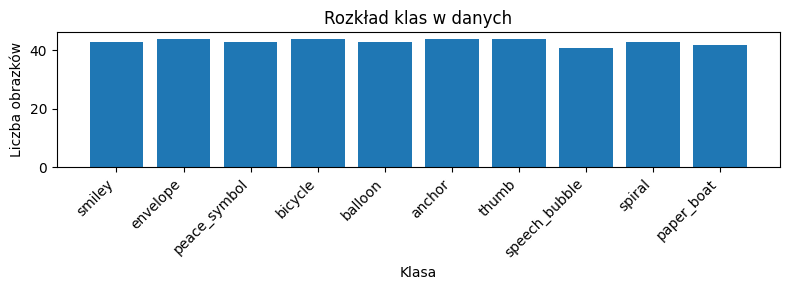

In [371]:
from collections import Counter

all_labels = [label for _, label in rawset.image_files]
label_counts = Counter(all_labels)
class_names = [classes[i] for i in label_counts.keys()]
counts = [label_counts[i] for i in label_counts.keys()]

plt.figure(figsize=(8, 3))
plt.bar(class_names, counts)
plt.xlabel("Klasa")
plt.ylabel("Liczba obrazków")
plt.title("Rozkład klas w danych")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 ...na szczęście w miarę równy. Gdyby było inaczej np. danych z jakiejś klasy byłoby za mało to model słabo by się nauczył tej klasy, a w przypadku za dużej ilości - nauczył tylko tej, a innych słabiej. Wtedy trzeba by było kombinować.

## Normalizacja danych
Zdecydowałem się na normalizację danych, ponieważ bardzo korzystnie wpływa to na szybkość uczenia się modelu, tym bardziej, że w zestawie danych znajdują się zdjęcia, które mogły być wykonane przy różnym oświetleniu i warunkach.

Normalizacja zdefiniowana jest przez wartości mean i std. Mogłem użyć domyślnych (0.5), ale znalazłem sposób żeby wygenerować je dla moich danych, co powinno zwiększyć skuteczność modelu.

In [372]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return np.array(mean), np.array(std)

mean, std = [0.5,0.5,0.5], [0.5,0.5,0.5]

if calculate_mean_std:
  mean, std = compute_mean_std(rawset)

print("Mean:", mean)
print("Std:", std)

Mean: [0.7570747 0.7570747 0.7570747]
Std: [0.10192278 0.10192278 0.10192278]


Potem sprawdziłem też wyniki dla wartości 0.5, ale na razie bez spoilerów.

## Powiększenie danych treningowych (Data augmentation)
Pytorch daje dostęp do prostego mechanizmu modyfikacji danych podczas treningu (transformacji). Służy to lepszemu wytrenowaniu modelu i pomaga uniknąć przetrenowania.

Jako że danych surowych jest bardzo mało, transformacje będą kluczowe, żeby zasymulować większą ich ilość.
Transformacje których użyłem to: odbicie horyzontalne, zmiany w kolorze/kontraście/saturacji, obrót i zmiana perspektywy.

Oprócz tego lekko zmniejszyłem rozmiar obrazku, żeby przyspieszyć trening.

In [374]:
# Transformacje treningowe
data_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(image_resize), # zmniejszenie rozmiaru
    transforms.RandomHorizontalFlip(), # losowe horyzontalne odbicie
    transforms.RandomRotation(10), # losowy obrót
    transforms.RandomPerspective(0.1), # zmiana perspektywy
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue = 0.3), # losowe zmiany koloru
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

# Transformacje testowe - losowe zmiany nie są potrzebne, bo model i tak nie widział tych danych podczas treningu
test_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(image_resize),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

fullset = CustomImageDataset(data_path, classes, data_transforms)

# Dzielimy dane na dwa zbiory: treningowy i testowy
train_size = int(train_data_percent * len(rawset))
test_size = len(rawset) - train_size
train_indices, test_indicies = random_split(list(range(len(rawset))), [train_data_percent, 1-train_data_percent])

trainset = CustomImageDataset(data_path, classes, data_transforms, train_indices)
testset = CustomImageDataset(data_path, classes, test_transforms, test_indicies)

print(f'Ilość danych treningowych {len(trainset)}')
print(f'Ilość danych testowych {len(testset)}')

batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Ilość danych treningowych 367
Ilość danych testowych 64


Wyświetliłem przykładowe obrazki i efekty transformacji:

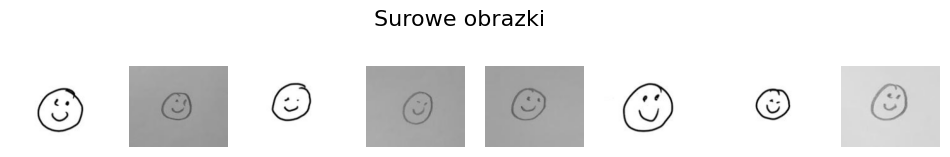

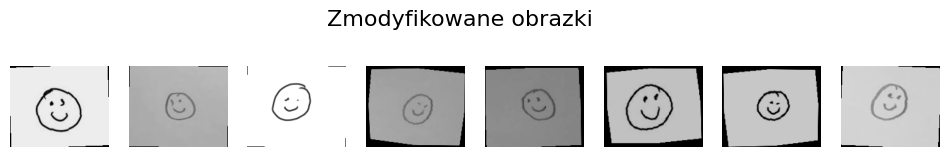

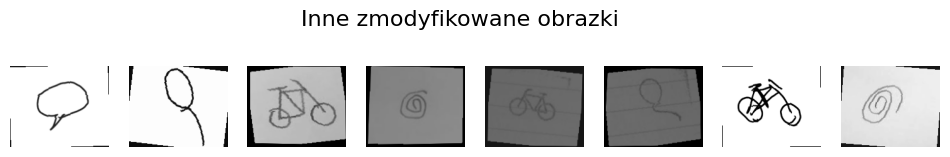

In [375]:
# funkcja do odwracania normalizacji
def unnormalize(img_tensor):
    global mean
    global std
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_images(dataset, title, unnormalize_image = True, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(12, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        data = dataset[i]
        if isinstance(data, tuple):
          img, _ = data
        else:
          img = data

        # zmien img tak aby byl obrazkiem w poprawnym formacie
        if unnormalize_image: img = unnormalize(img)
        elif isinstance(img, torch.Tensor):
             img = img.numpy().transpose((1, 2, 0))

        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

# Zobaczmy przykładowe obrazki
show_images(rawset, 'Surowe obrazki', False)
show_images(fullset, 'Zmodyfikowane obrazki', True)
show_images(trainset, 'Inne zmodyfikowane obrazki', True)

# Model

Jako model wybrałem CNN (Convolutional neural network). Jest to właściwy wybór, ponieważ ten typ sieci wzorowany jest na ludzkim wzroku i potrafi wykrywać wizualne cechy, nie ważne w którym miejscu obrazka się znajdują. Jest też polecany przez dokumentację pytorch :D

In [377]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, size_x, size_y):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Calculate the output size of the convolutional and pooling layers dynamically
        def output_size(input_size, kernel_size, stride, padding):
            return (input_size - kernel_size + 2 * padding) // stride + 1

        conv1_y = output_size(size_y, 5, 1, 0)
        conv1_x = output_size(size_x, 5, 1, 0)
        pool1_y = output_size(conv1_y, 2, 2, 0)
        pool1_x = output_size(conv1_x, 2, 2, 0)
        conv2_y = output_size(pool1_y, 5, 1, 0)
        conv2_x = output_size(pool1_x, 5, 1, 0)
        pool2_y = output_size(conv2_y, 2, 2, 0)
        pool2_x = output_size(conv2_x, 2, 2, 0)
        flattened_size = 16 * pool2_y * pool2_x


        self.fc1 = nn.Linear(flattened_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

size_y = rawset[0][0].size()[1]
size_x = rawset[0][0].size()[2]

print(f'Wymiary obrazków: {size_x}x{size_y}')

net = Net(size_x, size_y).cuda()

Wymiary obrazków: 157x128


Początkowo użyłem konstrukcji z dokumentacji pytorch, ale nie działała ze względu na różnicę wymiarów obrazków (moje nie były kwadratowe), dlatego zmodyfikowałem ją, aby działała dla dowolnych wymiarów. Tutaj wpadłem na pomysł przetestowania dokładności dla kwadratowych vs prostokątnych obrazków.

Żeby zwizualizować model użyłem biblioteki torchsummary.

In [378]:
%pip install torchsummary

In [380]:
from torchsummary import summary

summary(net, input_size=(3, size_y, size_x))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 153]             456
         MaxPool2d-2            [-1, 6, 62, 76]               0
            Conv2d-3           [-1, 16, 58, 72]           2,416
         MaxPool2d-4           [-1, 16, 29, 36]               0
            Linear-5                  [-1, 120]       2,004,600
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 2,018,486
Trainable params: 2,018,486
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 1.72
Params size (MB): 7.70
Estimated Total Size (MB): 9.65
----------------------------------------------------------------


Jak widać rozmiar modelu jest naprawdę mały, dwa miliony parametrów to nic w porównaniu do wielkich, współczesnych modeli.

Jako funkcję loss'u wybrałem proponowany przez pytorch Cross Entropy Loss, który jest zwyczajowo używany do zadań klasyfikacji, gdzie odpowiedź jest prawdopodobieństwem z zakresu [0, 1].

In [381]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Uruchomiłem trening modelu:

In [382]:
def test_on_dataset(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images = images.cuda()
          labels = labels.cuda()
          outputs = net(images) # predykcje modelu
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct // total

train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # optymalizacja
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss:.3f}')
    running_loss = 0.0
    train_accuracies.append(test_on_dataset(trainloader))
    test_accuracies.append(test_on_dataset(testloader))

print('Koniec treningu')

[1] loss: 53.052
[2] loss: 52.681
[3] loss: 52.171
[4] loss: 50.983
[5] loss: 47.939
[6] loss: 43.084
[7] loss: 38.191
[8] loss: 33.739
[9] loss: 31.066
[10] loss: 26.741
[11] loss: 24.846
[12] loss: 23.187
[13] loss: 20.453
[14] loss: 19.989
[15] loss: 19.685
[16] loss: 17.575
[17] loss: 18.538
[18] loss: 15.983
[19] loss: 15.981
[20] loss: 13.085
[21] loss: 14.674
[22] loss: 20.830
[23] loss: 12.730
[24] loss: 12.801
[25] loss: 16.142
[26] loss: 12.134
[27] loss: 14.176
[28] loss: 13.516
[29] loss: 10.260
[30] loss: 10.210
[31] loss: 9.132
[32] loss: 9.150
[33] loss: 9.562
[34] loss: 10.407
[35] loss: 12.087
[36] loss: 12.563
[37] loss: 11.553
[38] loss: 10.557
[39] loss: 8.192
[40] loss: 8.593
Koniec treningu


# Wyniki
### Wyniki tego treningu
Sprawdziłem wyniki zrobionego właśnie modelu na danych testowych, czyli takich których jeszcze nie widział.

In [383]:
test_accuracy = test_on_dataset(testloader)
print(f'Dokładność na danych testowych: {test_accuracy} %')

Dokładność na danych testowych: 76 %


Całkiem znośnie!

Byłem też ciekawy na ile dobrze radzi sobie z tym, co już widział.

In [384]:
train_accuracy = test_on_dataset(trainloader)
print(f'Dokładność na danych treningowych: {train_accuracy} %')

Dokładność na danych treningowych: 91 %


Możemy wyświetlić kilka obrazków i zobaczyć jak model je klasyfikuje.

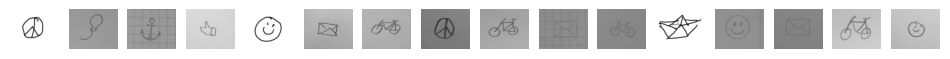

Poprawne klasy:       peace_symbol balloon anchor thumb smiley envelope bicycle peace_symbol bicycle envelope bicycle paper_boat smiley envelope bicycle smiley
Wypredykowane klasy:  peace_symbol balloon anchor spiral smiley envelope bicycle peace_symbol bicycle envelope bicycle paper_boat speech_bubble envelope bicycle smiley


In [385]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_cuda = images.cuda()
labels = labels.cuda()

show_images(images, '', True, num_images=len(images))

print('Poprawne klasy:      ', ' '.join(classes[label] for label in labels))

outputs = net(images_cuda)
_, predicted = torch.max(outputs, 1)
print('Wypredykowane klasy: ', ' '.join(classes[predict] for predict in predicted))

### Wyniki ogólne modelu
Zapisywałem wyniki uruchomień dla różnych ustawień, tak żeby później przeanalizować średnie wyniki.

Wybrałem ciekawiące mnie ustawienia - czy obrazek kwadratowy oraz czy wartości mean i std generowane dla moich danych.

In [386]:
# zapisywanie wyników tego treningu do .csv
import pandas as pd
import os

print(f"Wyniki na danych testowych: {test_accuracies}")
print(f"Wyniki na danych treningowych: {train_accuracies}")

file_name = 'wyniki_new.csv'

results = pd.DataFrame({
    'epoch': range(1, epochs + 1),
    'calculate_mean_std': calculate_mean_std,
    'square_images': square_images,
    'train_data_percent': train_data_percent,
    'test_accuracy': test_accuracies,
    'train_accuracy': train_accuracies
})

if os.path.exists(file_name): # dopisz wyniki do pliku
    prev_results = pd.read_csv(file_name)
    new_results = pd.concat([prev_results, results], ignore_index=True)
else:
    new_results = results

new_results.to_csv(file_name, index=False)
print(f"Zapisano wyniki do pliku: {file_name}")

Wyniki na danych testowych: [14, 14, 21, 29, 25, 42, 45, 42, 54, 46, 54, 64, 65, 65, 68, 75, 70, 65, 75, 76, 67, 57, 75, 73, 71, 71, 71, 71, 76, 75, 76, 76, 71, 78, 73, 75, 78, 70, 75, 76]
Wyniki na danych treningowych: [15, 13, 22, 29, 35, 44, 48, 50, 62, 62, 62, 68, 73, 74, 73, 74, 75, 74, 83, 82, 73, 78, 84, 79, 81, 83, 85, 84, 89, 89, 88, 89, 87, 89, 89, 88, 86, 92, 93, 92]
Zapisano wyniki do pliku: wyniki_new.csv


Wyświetlmy wyniki dla kolejnych epok i przeanalizujmy trendy:

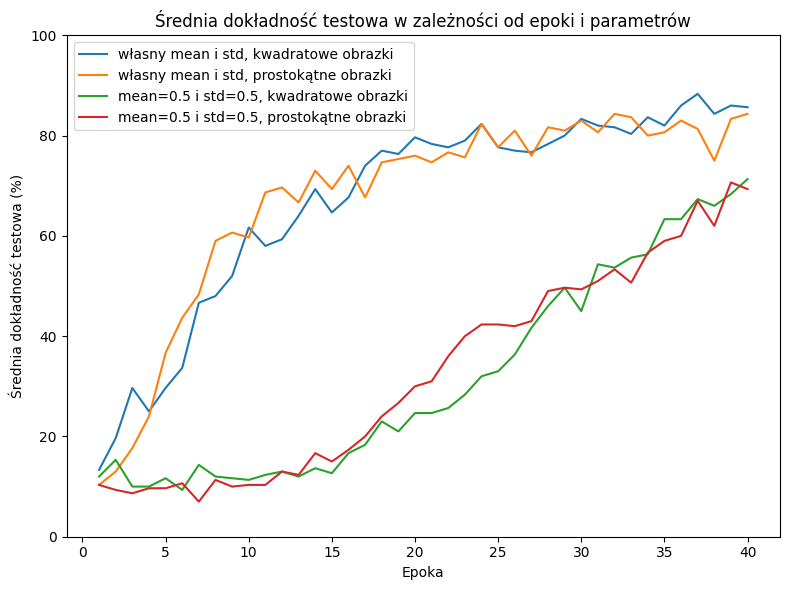

In [388]:
results = pd.read_csv('wyniki.csv')
results_test = results.groupby(['epoch', 'calculate_mean_std', 'square_images'])['test_accuracy'].mean().reset_index()
results_train = results.groupby(['epoch', 'calculate_mean_std', 'square_images'])['train_accuracy'].mean().reset_index()

def filter_data(grouped_data, calculate_mean_std, square_images):
  return grouped_data[(grouped_data['calculate_mean_std'] == calculate_mean_std) & (grouped_data['square_images'] == square_images)]

plot_test = {
    "własny mean i std, kwadratowe obrazki": filter_data(results_test, True, True),
    "własny mean i std, prostokątne obrazki": filter_data(results_test, True, False),
    "mean=0.5 i std=0.5, kwadratowe obrazki": filter_data(results_test, False, True),
    "mean=0.5 i std=0.5, prostokątne obrazki": filter_data(results_test, False, False),
}

plot_train = {
    "własny mean i std, kwadratowe obrazki": filter_data(results_train, True, True),
    "własny mean i std, prostokątne obrazki": filter_data(results_train, True, False),
    "mean=0.5 i std=0.5, kwadratowe obrazki": filter_data(results_train, False, True),
    "mean=0.5 i std=0.5, prostokątne obrazki": filter_data(results_train, False, False),
}

def print_results(plot, y, label_y, title):
  fig, ax = plt.subplots(figsize=(8, 6))

  for combination_key, df in plot.items():
      ax.plot(df['epoch'], df[y], label=combination_key)

  ax.set_xlabel("Epoka")
  ax.set_ylabel(label_y)
  ax.set_ylim([0, 100])
  ax.set_title(title)
  ax.legend()
  plt.tight_layout()
  plt.show()

print_results(plot_test, 'test_accuracy','Średnia dokładność testowa (%)','Średnia dokładność testowa w zależności od epoki i parametrów')



Sprawdźmy też jak model radził sobie z danymi, które już widział:

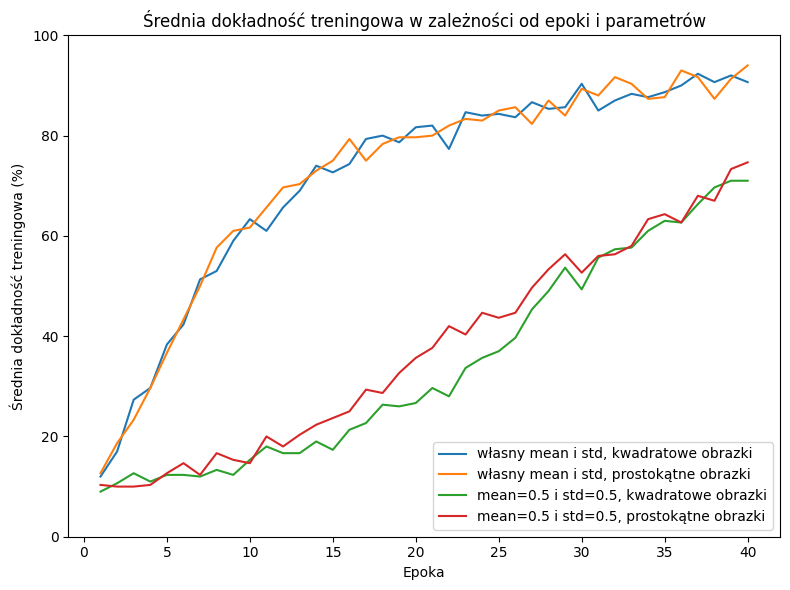

In [389]:
print_results(plot_train, 'train_accuracy','Średnia dokładność treningowa (%)','Średnia dokładność treningowa w zależności od epoki i parametrów')

# Wnioski i błędy

### Rozdzielenie danych treningowych i testowych
Na początku nie rozdzieliłem danych na treningowe i testowe przez co wynik był szokujący - aż 96%! Był to błąd, ponieważ nie sprawdzałem wyników modelu na nowych danych, tylko na tych, które już widział. Po poprawce wynik spadł do "normalnych" wartości.

### Liczba transformacji przy augmentacji danych
Danych było niewiele i ciekawiło mnie, jak ilość transformacji wpływa na wyniki.

Testowo zmieniłem liczbę różnych transformacji do dwóch (odbicie i zmiana koloru). Dokładność na danych testowych spadła o 10pp, podczas gdy na danych treningowych model uzyskiwał ponad 90% skuteczności - zdecydowanie się przetrenował.

Tak jak oczekiwałem, większa różnorodność danych pozytywnie wpłynęła na wynik dla niewidzianych wcześniej obrazków. Przy późniejszym generowaniu tabelki oszczędziłem sobie pracy i nie sprawdzałem wyników dla mniejszej liczby transformacji.

### Wymiary obrazków
Widziałem, że typowo obrazki wczytuje się do sieci jako kwadraty, ale uznałem, że spróbuję zostać przy prostokątach, dlatego finalnie przetestowałem obie opcje. Wyniki pokazały, że nie wpływa to znacząco na dokładność modelu.

### Własne wartości normalizujące vs generyczne
Jak widać na powyższych wykresach, własne wartości normalizujące niesamowicie poprawiały wyniki modelu.

Wyciągnąłem stąd wniosek, że dobre przygotowanie danych może drastycznie ułatwić/skrócić trenowanie modelu. Dla generycznych wartości model musiał wykonać ponad 3 razy więcej epok żeby osiągnąć ten sam wynik, co model z wygenerowanymi wartościami.

### Ogólne wyniki modelu
Model był trenowany od zera, przez co spodziewałem się, że wyniki będą słabe. Okazały się być bardzo dobre, to znaczy - przynajmniej mnie usatysfakcjonowały. Myślałem, że będę musiał użyć gotowej sieci i ją dotrenować, ale obyło się bez tego.

Wydaje mi się, że duża dokładność wynika z prostych cech w danych. Obrazki z zadania składają się z jednolitego tła i wyraźnych, czarnych linii. Gdyby tła były bardziej różnorodne niż kartka, model uczyłby się dłużej.

## Co dalej?
Rozwiązanie na pewno nie jest idealne. Z rzeczy, które mógłbym poprawić to pewnie jakość kodu (to zawsze się da).

Kolejnym krokiem w optymalizacji byłoby sprawdzenie innych modeli / konstrukcji sieci lub dotrenowanie jakiejś gotowej sieci CNN.

Dodatkowo, nie sprawdziłem parametrów, które mogłby okazać się istotne np. ile % danych jest do treningu, a ile do testu oraz wartości transformów przy augmentacji danych. Nie miałem też czasu sprawdzać wyników dla większej liczby epok.